# Description

TODO

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from IPython.display import HTML
from tqdm import tqdm

from clustering.methods import ClusterInterpreter
from data.recount2 import LVAnalysis
from data.cache import read_data
import conf

# Settings

In [3]:
SHORT_TRAIT_NAME = "ICD10_I70_Atherosclerosis"
FULL_TRAIT_NAME = "I70-Diagnoses_main_ICD10_I70_Atherosclerosis"
N_TOP_LVS = 50

# Paths

In [4]:
OUTPUT_DIR = conf.RESULTS["DRUG_DISEASE_ANALYSES"] / "lincs" / "analyses"
display(OUTPUT_DIR)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses/lincs/analyses')

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "drug_disease_prediction"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/drug_disease_prediction')

In [6]:
OUTPUT_FILE = OUTPUT_DIR / "cardiovascular-niacin.h5"
display(OUTPUT_FILE)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses/lincs/analyses/cardiovascular-niacin.h5')

# Load data

In [7]:
output_file = OUTPUT_DIR / "cardiovascular-niacin.h5"
display(output_file)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses/lincs/analyses/cardiovascular-niacin.h5')

In [8]:
with pd.HDFStore(output_file, mode="r", complevel=4) as store:
    top_lvs = store[f"traits/{SHORT_TRAIT_NAME}/top_lvs"]
    cell_types_data = store[f"traits/{SHORT_TRAIT_NAME}/cell_types"]
    tissues_data = store[f"traits/{SHORT_TRAIT_NAME}/tissues"]

In [9]:
top_lvs = top_lvs.head(N_TOP_LVS)

In [10]:
top_lvs.shape

(50,)

In [11]:
top_lvs.head()

LV116    0.006180
LV931    0.004843
LV744    0.002292
LV697    0.002231
LV885    0.001984
Name: I70-Diagnoses_main_ICD10_I70_Atherosclerosis, dtype: float64

In [12]:
cell_types_data.shape

(173682, 3)

In [13]:
cell_types_data.head()

,lv,attr,lv_name
0,2.307126,Neutrophils,LV116
1,2.151321,dermal fibroblast,LV116
2,2.047151,PBMCs,LV116
3,2.039088,PBMCs,LV116
4,2.031884,PBMCs,LV116


In [14]:
tissues_data.shape

(75235, 3)

In [15]:
tissues_data.head()

,lv,attr,lv_name
0,2.780800,Whole blood,LV116
1,2.343260,Whole blood,LV116
2,2.334816,Whole blood,LV116
3,2.324611,Whole blood,LV116
4,2.213722,Whole blood,LV116


# LVs selection

In [16]:
# N_TOP_LVS = 50

# Cell types

In [17]:
# def _get_lv_rank(data):
#     data = data.copy()
#     data["lv"] = data["lv"].rank()
#     return data

In [18]:
df = cell_types_data.copy()
# df = pd.concat(cell_type_dfs[:N_TOP_LVS], ignore_index=True)
# df = pd.concat([_get_lv_rank(x) for x in cell_type_dfs[:N_TOP_LVS]], ignore_index=True)

In [19]:
df = df[df["lv_name"].isin(top_lvs.index)]

In [20]:
df.shape

(173682, 3)

In [21]:
df.head()

,lv,attr,lv_name
0,2.307126,Neutrophils,LV116
1,2.151321,dermal fibroblast,LV116
2,2.047151,PBMCs,LV116
3,2.039088,PBMCs,LV116
4,2.031884,PBMCs,LV116


In [22]:
# this is an attempt to weight cell types by the top lvs from drug-disease

# _tmp = pd.merge(df, top_lvs.rename("lv_weight"), left_on="lv_name", right_index=True)
# _tmp = _tmp.assign(value=(_tmp["lv"] * _tmp["lv_weight"]))
# df = _tmp[["attr", "value", "lv"]]

In [23]:
# The PBMCs entry is related only to those samples treated with HSV-1
# see https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP045569
# here I keep only those, since the rest (sham) have almost zero expression
df = df[~((df["attr"] == "PBMCs") & (df["lv"] < 0.05))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP062958
df = df[~((df["attr"] == "peripheral blood monocytes") & (df["lv"] < 0.00))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP048804
df = df[~((df["attr"] == "glioblastoma cell line") & (df["lv"] < 0.00))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP066356
df = df[~((df["attr"] == "Monocyte") & (df["lv"] < 0.00))]

# https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015670
df = df[~((df["attr"] == "monocyte-derived macrophages") & (df["lv"] < 0.00))]

In [24]:
df.groupby("attr").median().squeeze().sort_values(ascending=False).head(25)
# df[["attr", "value"]].groupby("attr").median().squeeze().sort_values(ascending=False).head(40)
# df.groupby("attr").max().sort_values("lv", ascending=False).head(25)

attr
CD4+CD25highCD127low/- Treg cells                    7.645681
mural granulosa cells                                1.869020
cumulus granulosa cells                              1.846062
PBMCs                                                1.710010
HER2-positive breast cancer                          1.499028
WAT                                                  1.471362
human adipose-derived stem cells                     1.120623
peripheral blood monocytes                           1.024814
glioblastoma cell line                               0.981873
CD14 cells                                           0.893452
SGBS adipocyte D10                                   0.846062
limbal stem cells                                    0.831004
neural precursor cell derived neuronal like cells    0.803758
BAT                                                  0.777265
skin epithelial cells                                0.719672
Primary Monocytes(BC8)                               0.690342
Hep

In [25]:
df = df.replace(
    {
        "attr": {
            "CD14 cells": "CD14+ cells",
            "M1-polarized HMDM": "M1 macrophages\n(HMDM)",
            "M1-polarized IPSDM": "M1 macrophages\n(IPSDM)",
            "PBMCs": "PBMCs (HSV)",
            "peripheral blood monocytes": "Monocytes (IFNa)",
            "LHSAR overexpressed with HOXB13": "Prostate epithelial cells (LHSAR)",
            "LHSAR overexpressed with HOXB13 and FOXA1": "Prostate epithelial cells (LHSAR)",
            "LHSAR overexpressed with LacZ": "Prostate epithelial cells (LHSAR)",
            "Primary Monocytes(BC8)": "Primary monocytes",
            "Primary Monocytes(BC9)": "Primary monocytes",
            "Primary Monocytes(BC12)": "Primary monocytes",
            "Primary Monocytes(BC11)": "Primary monocytes",
            "glioblastoma cell line": "Glioblastoma (GBM1A cell line)",
            "Monocyte": "Monocytes",
            "monocyte-derived macrophages": "Monocyte-derived\nmacrophages (WNV)",
            "Tongue squamous cell carcinoma": "Tongue squamous\ncell carcinoma",
            "CD4+CD25highCD127low/- Treg cells": "Regulatory T cells (Treg)",
            "WAT": "White adipose tissue",
            "BAT": "Brown adipose tissue",
            "human adipose-derived stem cells": "Adipose-derived stem cells",
            "neural precursor cell derived neuronal like cells": "Neural precursor cell",
            "Neural crest cells (hNCC) derived from H9 ESC": "Neural crest cells",
            "NPC": "Neural progenitor cell",
        }
    }
)

In [26]:
cat_order = df.groupby("attr").median().squeeze()
cat_order = cat_order.sort_values(ascending=False)
cat_order = cat_order.head(20)
cat_order = cat_order.index

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/drug_disease_prediction/niacin-ICD10_I70_Atherosclerosis-cell_types.svg')

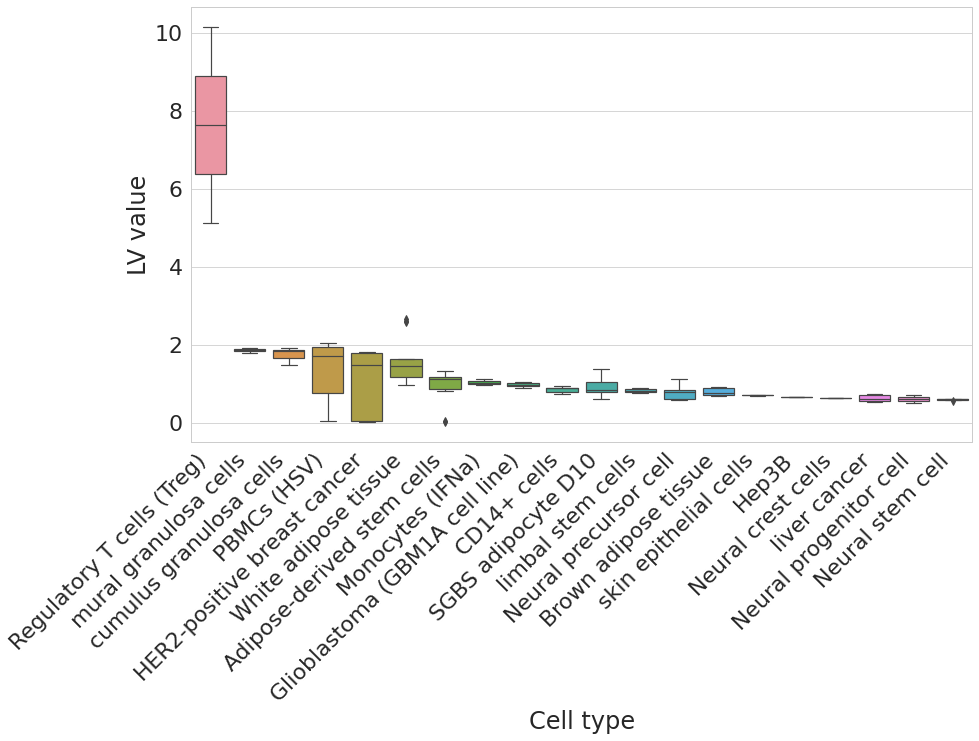

In [27]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(14, 8))
    ax = sns.boxplot(
        data=df,
        x="attr",
        y="lv",
        order=cat_order,
        linewidth=None,
        ax=ax,
    )

    ax.set_xlabel("Cell type")
    ax.set_ylabel("LV value")
    plt.xticks(rotation=45, horizontalalignment="right")

    output_filepath = OUTPUT_FIGURES_DIR / f"niacin-{SHORT_TRAIT_NAME}-cell_types.svg"
    display(output_filepath)
    plt.savefig(
        output_filepath,
        bbox_inches="tight",
    )

# Debug

In [28]:
df[df["attr"].str.contains("NPC")]

,lv,attr,lv_name
142005,0.816105,iPSC (GM8330-8)-derived NPC,LV879
142009,0.810455,iPSC (GM8330-8)-derived NPC,LV879
142010,0.808660,iPSC (GM8330-8)-derived NPC,LV879
142017,0.768757,iPSC (GM8330-8)-derived NPC,LV879
142018,0.767118,iPSC (GM8330-8)-derived NPC,LV879
142021,0.761991,iPSC (GM8330-8)-derived NPC,LV879
142022,0.761510,iPSC (GM8330-8)-derived NPC,LV879
142026,0.738662,iPSC (GM8330-8)-derived NPC,LV879
142028,0.735728,iPSC (GM8330-8)-derived NPC,LV879
142033,0.724999,iPSC (GM8330-8)-derived NPC,LV879


In [29]:
LV_NAME = "LV879"

In [30]:
lv_obj = LVAnalysis(LV_NAME, None)

In [31]:
lv_data = lv_obj.get_experiments_data()

SRP041179, SRP048761, SRP002079, SRP039397, SRP047194, SRP047233, SRP049553, SRP017684, SRP045876, SRP022028, SRP061416, SRP045308, SRP006561, SRP041738, SRP047516, SRP060650, SRP063669, SRP018848, SRP035482, SRP035417, SRP013999, SRP033432, SRP058804, SRP041159, SRP049340, SRP028804, SRP039346, SRP064624, SRP046749, SRP032928, SRP049203, SRP013825, SRP033267, SRP049475, SRP047339, SRP041377, SRP037579, SRP061682, SRP055569, SRP028118, SRP050499, SRP032798, SRP056957, SRP059205, SRP041751, SRP008225, SRP014671, SRP048825, SRP036821, SRP040525, SRP056076, SRP021134, SRP055440, SRP003021, SRP016140, 

In [32]:
lv_data.shape

(1958, 69)

In [33]:
lv_data.head()

Stage     cell type    run id  \
project   run                                                         
SRP041179 SRR1238493           Pluripotency  hESC (WA-09)  Cortecon   
          SRR1238494           Pluripotency  hESC (WA-09)  Cortecon   
          SRR1238495           Pluripotency  hESC (WA-09)  Cortecon   
          SRR1238496           Pluripotency  hESC (WA-09)  Cortecon   
          SRR1238498  Neural Differentation  hESC (WA-09)  Cortecon   

                     genetic background developmental stage antibody  \
project   run                                                          
SRP041179 SRR1238493                NaN                 NaN      NaN   
          SRR1238494                NaN                 NaN      NaN   
          SRR1238495                NaN                 NaN      NaN   
          SRR1238496                NaN                 NaN      NaN   
          SRR1238498                NaN                 NaN      NaN   

                     cell line condition dynamic program knockdown  ...  \
project   run                                                       ...   
SRP041179 SRR1238493       NaN       NaN             NaN       NaN  ...   
          SRR1238494       NaN       NaN             NaN       NaN  ...   
          SRR1238495       NaN       NaN             NaN       NaN  ...   
          SRR1238496       NaN       NaN             NaN       NaN  ...   
          SRR1238498       NaN       NaN             NaN       NaN  ...   

                     tissue archive method source differential stage  \
project   run                                                          
SRP041179 SRR1238493                   NaN    NaN                NaN   
          SRR1238494                   NaN    NaN                NaN   
          SRR1238495                   NaN    NaN                NaN   
          SRR1238496                   NaN    NaN                NaN   
          SRR1238498                   NaN    NaN                NaN   

                     gestational age (weeks) facs population  \
project   run                                                  
SRP041179 SRR1238493                     NaN             NaN   
          SRR1238494                     NaN             NaN   
          SRR1238495                     NaN             NaN   
          SRR1238496                     NaN             NaN   
          SRR1238498                     NaN             NaN   

                     antibody batch/lot# antibody catalog# antibody vendor  \
project   run                                                                
SRP041179 SRR1238493                 NaN               NaN             NaN   
          SRR1238494                 NaN               NaN             NaN   
          SRR1238495                 NaN               NaN             NaN   
          SRR1238496                 NaN               NaN             NaN   
          SRR1238498                 NaN               NaN             NaN   

                     chromosome     LV879  
project   run                              
SRP041179 SRR1238493        NaN  0.100898  
          SRR1238494        NaN  0.103558  
          SRR1238495        NaN  0.115096  
          SRR1238496        NaN  0.111061  
          SRR1238498        NaN  1.203854  

[5 rows x 69 columns]

In [34]:
import numpy as np

In [35]:
mask = np.column_stack(
    [lv_data[col].str.contains("^NPC$", na=False) for col in lv_data if col != LV_NAME]
)

In [36]:
lv_data.loc[mask.any(axis=1)]

Stage cell type run id genetic background  \
project   run                                                   
SRP017684 SRR640259   NaN       NPC    NaN                NaN   
          SRR950429   NaN       NPC    NaN                NaN   

                    developmental stage antibody cell line condition  \
project   run                                                          
SRP017684 SRR640259                 NaN      NaN       NaN       NaN   
          SRR950429                 NaN      NaN       NaN       NaN   

                    dynamic program knockdown  ... tissue archive method  \
project   run                                  ...                         
SRP017684 SRR640259             NaN       NaN  ...                   NaN   
          SRR950429             NaN       NaN  ...                   NaN   

                    source differential stage gestational age (weeks)  \
project   run                                                           
SRP017684 SRR640259    NaN                NaN                     NaN   
          SRR950429    NaN                NaN                     NaN   

                    facs population antibody batch/lot# antibody catalog#  \
project   run                                                               
SRP017684 SRR640259             NaN                 NaN               NaN   
          SRR950429             NaN                 NaN               NaN   

                    antibody vendor chromosome     LV879  
project   run                                             
SRP017684 SRR640259             NaN        NaN  0.517831  
          SRR950429             NaN        NaN  0.714183  

[2 rows x 69 columns]

In [37]:
# what is there in these projects?
lv_data.loc[["SRP017684"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(10)

cell type     LV879
project   run                          
SRP017684 SRR950429       NPC  0.714183
          SRR640259       NPC  0.517831
          SRR950427    neuron  0.430711
          SRR640257    neuron  0.386341
          SRR640258      iPSC  0.194317
          SRR950428      iPSC  0.134221

In [38]:
_tmp = lv_data[["cell type", "LV116"]].dropna()

KeyError: "['LV116'] not in index"

In [ ]:
# _tmp[_tmp["cell type"].str.contains("M1")]

In [ ]:
# _tmp[_tmp["cell type"].str.contains("CD14")]

# Tissues

In [ ]:
# df = tissues_data.copy()

In [ ]:
# df.shape

In [ ]:
# df.head()

In [ ]:
# df.groupby("attr").median().squeeze().sort_values(ascending=False).head(25)
# # df.groupby("attr").max().sort_values("lv", ascending=False).head(25)

# LV analysis

In [ ]:
# lv_obj = LVAnalysis("LV116", data)

In [ ]:
# lv_obj.lv_genes.head(20)

In [ ]:
# lv_data = lv_obj.get_experiments_data()

In [ ]:
# lv_data.shape

In [ ]:
# _tmp = lv_data[["cell type", "LV116"]].dropna()

In [ ]:
# _tmp[_tmp["cell type"].str.contains("M1")]

In [ ]:
# _tmp[_tmp["cell type"].str.contains("CD14")]